In [1]:
# Cosmology
%pip install colossus

# Inference
%pip install sbi
%pip install emcee

# Plotting
%pip install pygtc
%pip install chainconsumer

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import json
from matplotlib import pyplot as plt
# from context import weaklensclustersbi as wlcs

# Simulation

To train our inferrer for Simulation-Based Inference (SBI), we'll need to generate some simulations. These are the data points from which we can learn the relationship between m-c pairs and NFW profiles that we'll use later in this tutorial for inference.

## Configuration

First, we'll load in an example simulation config and look at the example config values. For the different numerical experiments, we'll tweak these and use different combinations of configs, but this is a good representative example of what a sim config could be.

In [3]:
# Command line arguments for generating simulations
SIM_ID = 1
NUM_SIMS = 1000

with open(f'configs/simulations/{SIM_ID}.json', 'r') as f:
    sim_config = json.load(f)
    
print(json.dumps(sim_config, indent=2))

{
  "mc_relation": "child18",
  "mc_scatter": 0.1,
  "min_log10mass": 13,
  "max_log10mass": 15,
  "num_radial_bins": 30,
  "mc_pair_subselect": "all",
  "z": 0
}


## Generating Simulations

To use this sim_config to generate our simulations, we do the following:
1) randomly select `NUM_SIMS` log10masses in the defined range (`min_log10mass`, `max_log10mass`)
2) use the `mc_relation` (with some `mc_scatter` and redshift, `z`) to find the corresponding concentrations
3) filter these mc_pairs based on the `mc_pair_subselect` criteria
4) generate NFW profiles with `num_radial_bins` radial bins
5) output the `sample_mc_pairs` and the `simulated_nfw_profiles` as `.npy` files

In [4]:
%run scripts/gen_simulations.py --sim_id {SIM_ID} --num_sims {NUM_SIMS}

In [5]:
# Confirming the output files were generated correctly
sim_output_dir = f'outputs/simulations/{SIM_ID}.{NUM_SIMS}'
%ls {sim_output_dir}

sample_mc_pairs.npy         simulated_nfw_profiles.npy


Let's look at the `sample_mc_pairs` to make sure they look correct. We expect to see our predicted m-c relation with some scatter applied to it.

(1000, 2)
[[14.29331205  5.81833622]
 [13.5750043   6.59947855]
 [13.16172715  7.16978119]
 [13.45138202  6.6351312 ]
 [14.95614908  4.67830112]]


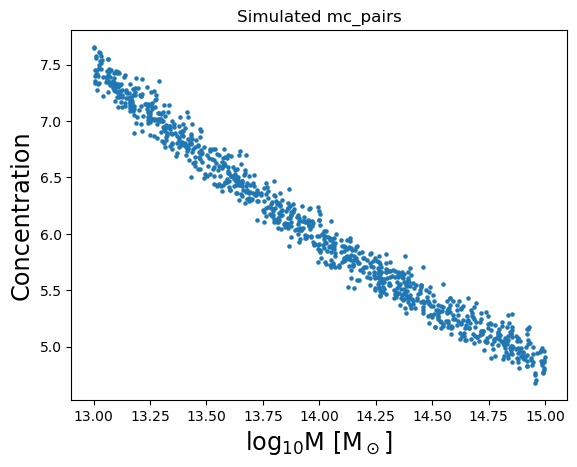

In [6]:
sample_mc_pairs = np.load(f'{sim_output_dir}/sample_mc_pairs.npy')

# (num_parameter_samples, 2)
print(np.shape(sample_mc_pairs))

# 5 example mc_pairs
print(sample_mc_pairs[:5])

# mc_pairs scatter plot
plt.scatter(sample_mc_pairs[:,0], sample_mc_pairs[:,1],s=5)
plt.xlabel('log$_{10}$M [M$_\odot$]', fontsize='xx-large')
plt.ylabel('Concentration', fontsize='xx-large')
plt.title('Simulated mc_pairs')
plt.show()

# Observations

Now, let's generate some "observations", which are mock NFW profiles that we'll treat as empirical data. We'll use these for both MCMC and SBI later in the notebook.

## Configuration
Similar to our approach above, let's look at an example observation config so we can inspect what we can tweak in numerical experiments.

In [7]:
# Command line arguments for generating simulations
OBS_ID = 1
NUM_OBS = 20

with open(f'configs/observations/{OBS_ID}.json', 'r') as f:
    obs_config = json.load(f)
    
print(json.dumps(obs_config, indent=2))

{
  "rm_relation": "murata17",
  "mc_relation": "child18",
  "min_richness": 30,
  "max_richness": 40,
  "rm_scatter": 0,
  "mc_scatter": 0,
  "profile_noise_dex": 0.01,
  "num_radial_bins": 30,
  "z": 0
}


## Generating Observations

To use this obs_config to generate our observations, we do the following:
1) randomly select `NUM_OBS` richnesses ($\lambda$) in the defined range (`min_richness`, `max_richness`)
2) use the `rm_relation` (with some `rm_scatter`) to find the corresponding log10masses
3) use the `mc_relation` (with some `mc_scatter` and redshift, `z`) to find the corresponding concentrations
4) generate NFW profiles with `num_radial_bins` radial bins and some `profile_noise_dex` applied to them
5) output the `drawn_mc_pairs` and the `drawn_nfw_profiles` as `.npy` files

In [8]:
%run scripts/gen_observations.py --obs_id {OBS_ID} --num_obs {NUM_OBS}

In [9]:
# Confirming the output files were generated correctly
obs_output_dir = f'outputs/observations/{OBS_ID}.{NUM_OBS}'
%ls {obs_output_dir}

drawn_mc_pairs.npy      drawn_nfw_profiles.npy


First, let's look at the drawn_mc_pairs from the given richness bin

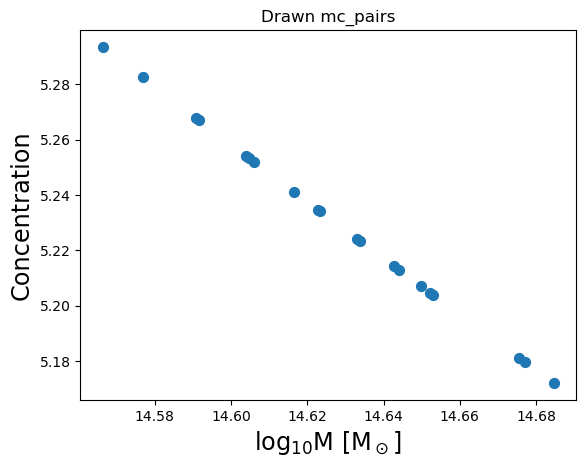

In [10]:
drawn_mc_pairs = np.load(f'{obs_output_dir}/drawn_mc_pairs.npy')
drawn_nfw_profiles = np.load(f'{obs_output_dir}/drawn_nfw_profiles.npy')


# drawn_mc_pairs scatter plot
plt.scatter(drawn_mc_pairs[:,0], drawn_mc_pairs[:,1],s=50)
plt.xlabel('log$_{10}$M [M$_\odot$]', fontsize='xx-large')
plt.ylabel('Concentration', fontsize='xx-large')
plt.title('Drawn mc_pairs')
plt.show()

Next, we can look at the drawn_nfw_profiles which we generated from the above drawn_mc_pairs.

In [11]:
# (num_sims, num_radial_bins)
print(np.shape(drawn_nfw_profiles))

(20, 30)


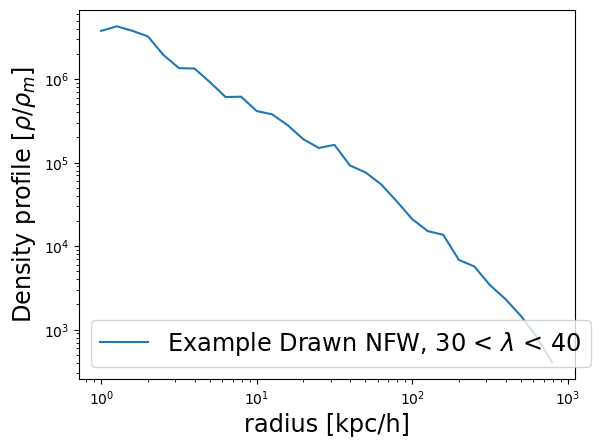

In [12]:
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck18')

# TODO: Show example vs mean NFW profile

rbins = 10**np.arange(0, sim_config['num_radial_bins'] / 10, 0.1)
plt.figure()
plt.loglog()
plt.xlabel('radius [kpc/h]', fontsize='xx-large')
plt.ylabel('Density profile [$\\rho/\\rho_m$]', fontsize='xx-large')
plt.plot(rbins, drawn_nfw_profiles[0] / cosmo.rho_m(0), '-', label = f'Example Drawn NFW, {obs_config["min_richness"]} < $\lambda$ < {obs_config["max_richness"]}')
plt.legend(fontsize='xx-large');

# Inference

Now we'll need to infer the association between the input m-c pairs and the output NFW profiles. MCMC will do this with a likelihood function and SBI will do this with an inferrer trained on the simulated data points and their corresponding NFW profiles. Both of these inferrers will have the observations applied to them, which can then show us the posterior distribution.

## Configuration

Similarly to what we did before, we'll generate an infer_config in our directory of interest and look at an example of what these values could be.

In [13]:
# Command line arguments for generating simulations
INFER_ID = 1

with open(f'configs/inference/{INFER_ID}.json', 'r') as f:
    infer_config = json.load(f)
    
print(json.dumps(infer_config, indent=2))

{
  "priors": {
    "min_log10mass": 0,
    "max_log10mass": 20,
    "min_concentration": 0,
    "max_concentration": 20
  }
}


## Run Inference

To actually run inference, we do the following:
1) train the SBI inferrer, which (despite the misleading nomenclature of "posterior") is actually just the trained inferrer (i.e. it will become the posterior later when we apply it to observations)
2) run inference
    1) with MCMC (using the likelihood function and observations)
    2) with SBI (using simulations, observations, and trained inferrer)

The reason we split these two steps is so we can train an SBI inferrer and apply it to many different sets of observations without redundant computing.

In [14]:
%run scripts/gen_posterior.py --sim_id {SIM_ID} --infer_id {INFER_ID} --num_sims {NUM_SIMS}

 Neural network successfully converged after 72 epochs.

This is a pretty time intensive step (~5 minutes). If you want to stretch your legs and/or refill your cup of coffee, this is a good time to do so.

In [15]:
%run scripts/run_inference.py --sim_id {SIM_ID} --infer_id {INFER_ID} --obs_id {OBS_ID} --num_sims {NUM_SIMS} --num_obs {NUM_OBS}
print("Completed running inference")

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/Users/akumgill/anaconda3/lib/python3.11/site-packages/pyknos/mdn/mdn.py:283: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_1aidzjezue/croot/pytorch_1687856425340/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2197.)
  zero_mean_samples, _ = torch.triangular_solve(


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 257.30it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 259.37it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 269.53it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 279.62it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 261.61it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 247.10it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 255.34it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 274.59it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 250.82it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 276.31it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 262.35it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 254.26it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 253.04it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 258.44it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 269.50it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 272.28it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 255.59it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 253.70it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 247.60it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 251.80it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 302.98it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 282.79it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 301.54it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 281.87it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 249.97it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 255.64it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 259.94it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 250.49it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 245.05it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 253.18it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 254.64it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 269.69it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 271.14it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 248.82it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 263.52it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 269.16it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 251.54it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 254.71it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 244.75it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 247.49it/s]


## burning in ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 263.17it/s]


## running the full chain ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 279.05it/s]

Completed running inference


## Plotting

Now we can plot the confusogram/corner plots/banana plots.

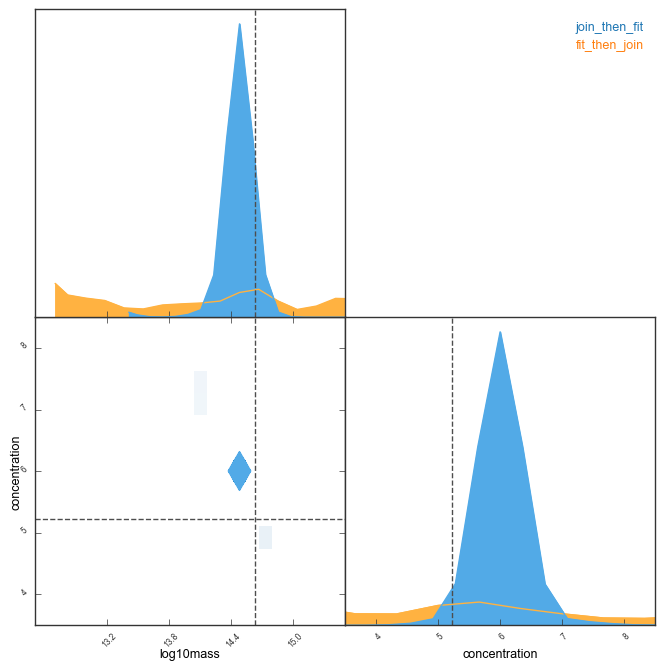

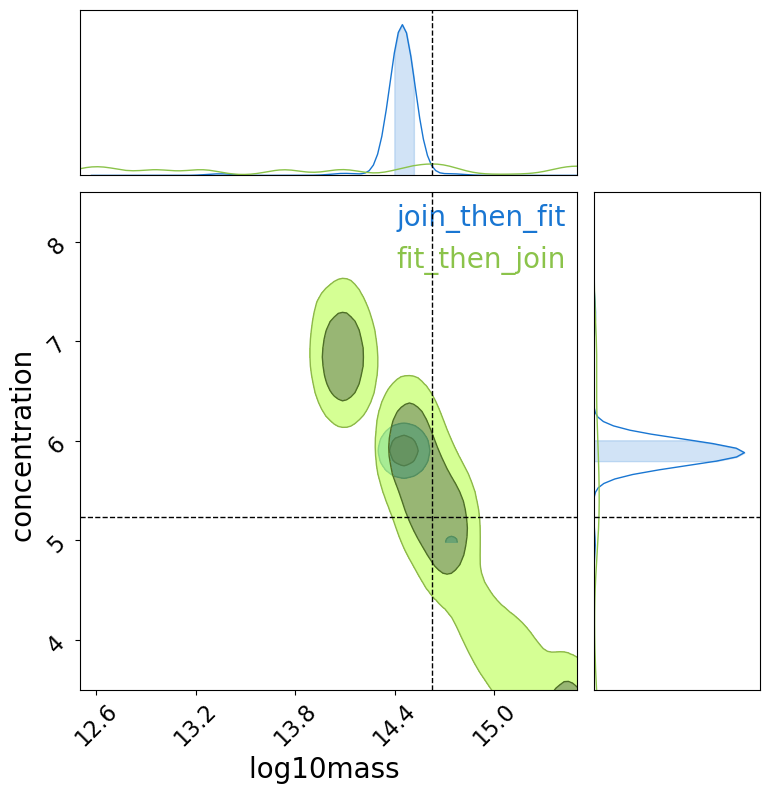

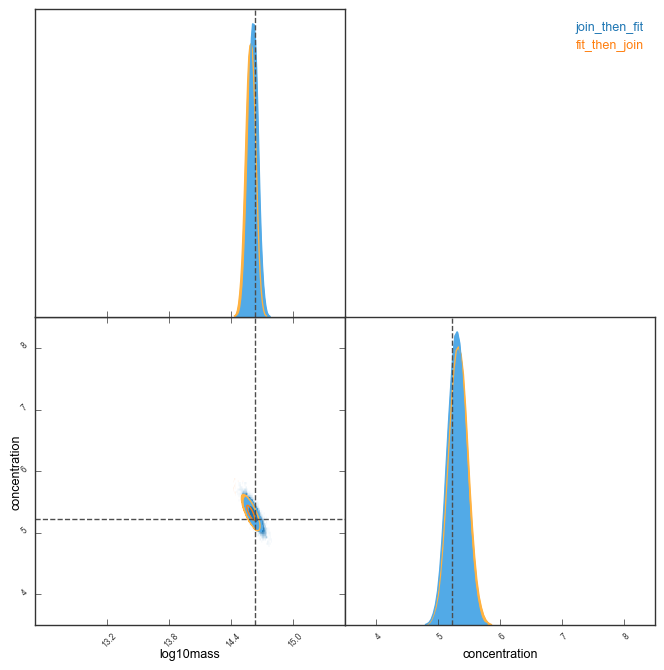

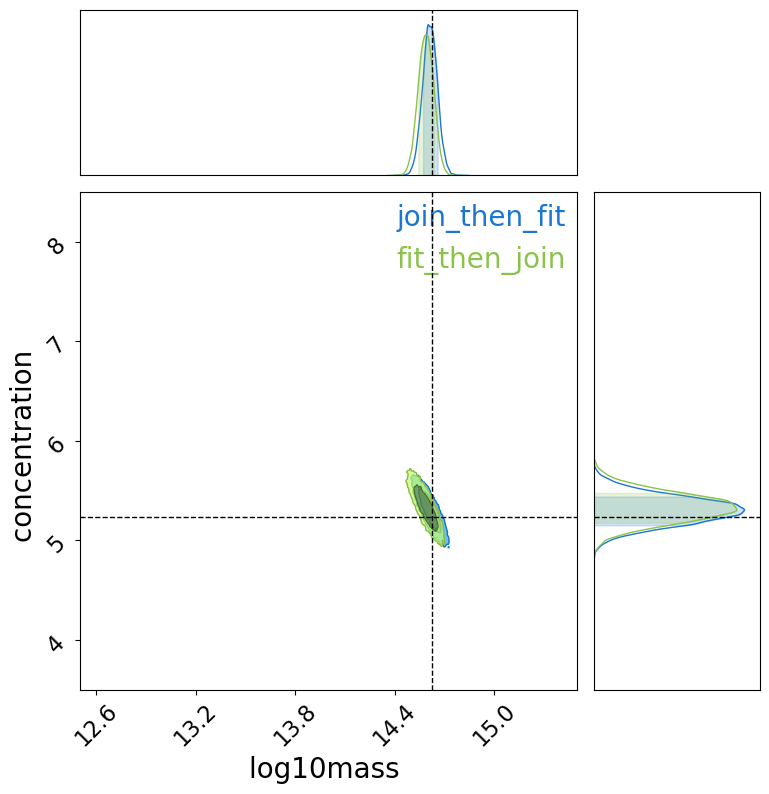

In [16]:
%run scripts/plot_chains.py --sim_id {SIM_ID} --infer_id {INFER_ID} --obs_id {OBS_ID} --num_sims {NUM_SIMS} --num_obs {NUM_OBS}